Mean Squared Error scores: [115.91870578 196.89968257 239.95134963 309.51122666 383.64909976]
R^2 scores: [0.42559893 0.29763083 0.34502741 0.4036617  0.48404885]
Average Mean Squared Error: 249.1860128803869
Average R^2 score: 0.3911935432268594
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Mean Squared Error: 113.35776096549812
R^2 Score: 0.7140431658831059


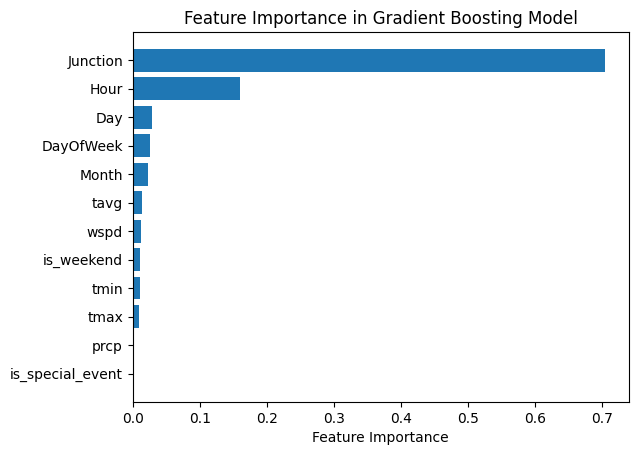

In [3]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Load data
data = pd.read_csv('Integrated_Dataset_Akshansh_Roy.csv', parse_dates=['datetime'])

# Sort by datetime
data.sort_values(by='datetime', inplace=True)

# Feature engineering using .loc
data.loc[:, 'Hour'] = data['datetime'].dt.hour
data.loc[:, 'Day'] = data['datetime'].dt.day
data.loc[:, 'Month'] = data['datetime'].dt.month
data.loc[:, 'DayOfWeek'] = data['datetime'].dt.dayofweek

features = ['Junction', 'Hour', 'Day', 'Month', 'DayOfWeek', 'is_weekend', 
            'is_special_event', 'tavg', 'tmin', 'tmax', 'prcp', 'wspd']
X = data[features]
y = data['Vehicles']

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the model
model = GradientBoostingRegressor(random_state=42)

# Cross_val_score with the time series split
mse_scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')

print(f'Mean Squared Error scores: {-mse_scores}')
print(f'R^2 scores: {r2_scores}')
print(f'Average Mean Squared Error: {-mse_scores.mean()}')
print(f'Average R^2 score: {r2_scores.mean()}')

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# Initialize GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with optimal hyperparameters
best_model = GradientBoostingRegressor(**best_params, random_state=42)
best_model.fit(X, y)

# Model evaluation on the entire dataset
y_pred = best_model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Feature importance
feature_importances = best_model.feature_importances_
sorted_idx = np.argsort(feature_importances)
plt.barh(np.array(features)[sorted_idx], feature_importances[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting Model')
plt.show()


In [4]:
# Calculate cross-validation scores
mse_scores = cross_val_score(best_model, X, y, cv=tscv, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(best_model, X, y, cv=tscv, scoring='r2')

# Convert negative MSE scores to positive for easier interpretation
mse_scores = -mse_scores

# Print cross-validation scores
print(f'Cross-Validation Mean Squared Error scores: {mse_scores}')
print(f'Cross-Validation R² scores: {r2_scores}')

# Calculate and print average scores
avg_mse = mse_scores.mean()
avg_r2 = r2_scores.mean()
print(f'Average Mean Squared Error: {avg_mse}')
print(f'Average R² score: {avg_r2}')

# Calculate standard deviation of the scores
std_mse = mse_scores.std()
std_r2 = r2_scores.std()
print(f'Standard Deviation of Mean Squared Error: {std_mse}')
print(f'Standard Deviation of R² score: {std_r2}')


Cross-Validation Mean Squared Error scores: [115.91870578 196.89968257 239.95134963 309.51122666 383.64909976]
Cross-Validation R² scores: [0.42559893 0.29763083 0.34502741 0.4036617  0.48404885]
Average Mean Squared Error: 249.1860128803869
Average R² score: 0.3911935432268594
Standard Deviation of Mean Squared Error: 91.9769184474908
Standard Deviation of R² score: 0.06457025356035098


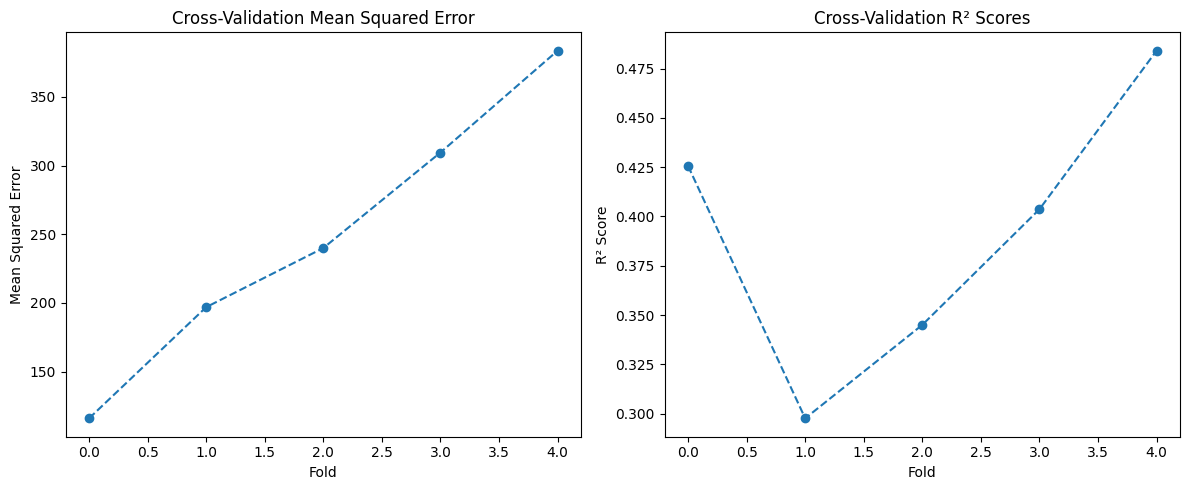

In [5]:
import matplotlib.pyplot as plt

# Plot MSE scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mse_scores, marker='o', linestyle='--')
plt.title('Cross-Validation Mean Squared Error')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')

# Plot R² scores
plt.subplot(1, 2, 2)
plt.plot(r2_scores, marker='o', linestyle='--')
plt.title('Cross-Validation R² Scores')
plt.xlabel('Fold')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()


In [6]:
# Interpretation of results
print("\nInterpretation of Cross-Validation Results:")

# Check for overfitting or underfitting
if avg_r2 < 0.5:
    print("The model might be underfitting the data. Consider increasing model complexity or adding more features.")
elif avg_r2 > 0.8 and std_r2 > 0.1:
    print("The model might be overfitting the data. Consider reducing model complexity or using regularization techniques.")
else:
    print("The model shows a good fit with a balance between bias and variance.")

# Consistency check
if std_mse < 0.1 * avg_mse:
    print("The model performance is consistent across different folds.")
else:
    print("The model performance varies significantly across different folds.")



Interpretation of Cross-Validation Results:
The model might be underfitting the data. Consider increasing model complexity or adding more features.
The model performance varies significantly across different folds.


Performing Grid Search...
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best parameters from Grid Search: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
Performing Random Search...
Fitting 2 folds for each of 10 candidates, totalling 20 fits


C:\Users\amban\myenv\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [         nan -20.05582663 -19.8901915           nan          nan
 -18.66754939 -19.33660356          nan          nan -18.5075894 ]
  warnings.warn(


Best parameters from Random Search: {'learning_rate': 0.11803075385877798, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 138, 'subsample': 0.8132649611598666}
Grid Search - Mean Squared Error: 52.98639051060417, R² Score: 0.9261962118653101
Random Search - Mean Squared Error: 45.8522848803505, R² Score: 0.9361331789882238


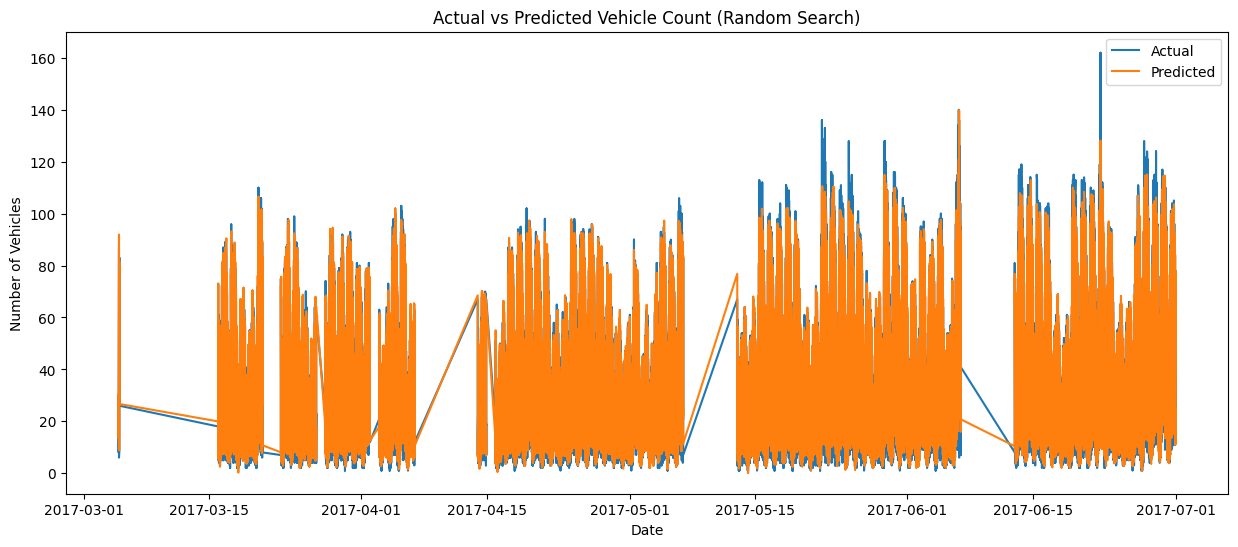

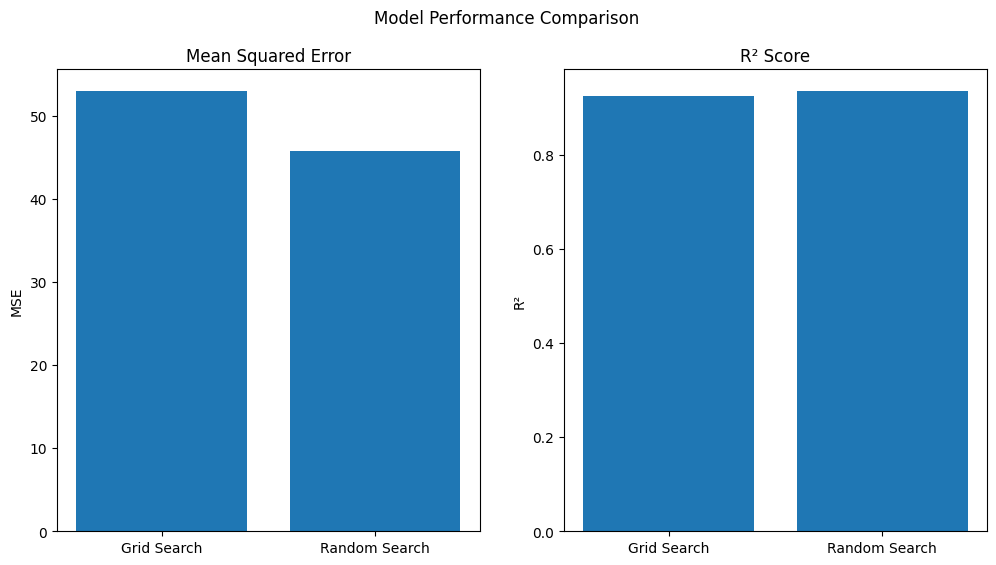

The model shows a good fit with a balance between bias and variance.


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

# Load data
data = pd.read_csv('Integrated_Dataset_Akshansh_Roy.csv', parse_dates=['datetime'])

# Sort by datetime
data.sort_values(by='datetime', inplace=True)

# Feature engineering
data['Hour'] = data['datetime'].dt.hour
data['Day'] = data['datetime'].dt.day
data['Month'] = data['datetime'].dt.month
data['DayOfWeek'] = data['datetime'].dt.dayofweek

# Adding lag features
for lag in range(1, 25):
    data[f'Vehicles_lag_{lag}'] = data['Vehicles'].shift(lag)

# Adding rolling statistics
data['Vehicles_roll_mean_3'] = data['Vehicles'].rolling(window=3).mean()
data['Vehicles_roll_mean_6'] = data['Vehicles'].rolling(window=6).mean()
data['Vehicles_roll_mean_12'] = data['Vehicles'].rolling(window=12).mean()
data['Vehicles_roll_std_3'] = data['Vehicles'].rolling(window=3).std()
data['Vehicles_roll_std_6'] = data['Vehicles'].rolling(window=6).std()

# Dropping rows with NaN values generated by lag and rolling features
data.dropna(inplace=True)

# Defining features
features = ['Junction', 'Hour', 'Day', 'Month', 'DayOfWeek', 'is_weekend', 
            'is_special_event', 'tavg', 'tmin', 'tmax', 'prcp', 'wspd'] + \
           [f'Vehicles_lag_{lag}' for lag in range(1, 25)] + \
           ['Vehicles_roll_mean_3', 'Vehicles_roll_mean_6', 'Vehicles_roll_mean_12',
            'Vehicles_roll_std_3', 'Vehicles_roll_std_6']

X = data[features]
y = data['Vehicles']

# Time-based split: Use the first 80% of the data for training and the last 20% for validation
split_index = int(len(data) * 0.8)
X_train, X_valid = X[:split_index], X[split_index:]
y_train, y_valid = y[:split_index], y[split_index:]

# Define Gradient Boosting Regressor
model = GradientBoostingRegressor(random_state=42)

# Define a simplified parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# Define a simplified parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 150),
    'learning_rate': uniform(0.05, 0.1),
    'max_depth': randint(3, 4),
    'subsample': uniform(0.8, 1.0),
    'min_samples_split': randint(2, 4),
    'min_samples_leaf': randint(1, 2)
}

# Perform grid search with time-based cross-validation
tscv = TimeSeriesSplit(n_splits=2)  

print("Performing Grid Search...")
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_model_grid = grid_search.best_estimator_
print(f'Best parameters from Grid Search: {grid_search.best_params_}')

# Perform random search with time-based cross-validation
print("Performing Random Search...")
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)
best_model_random = random_search.best_estimator_
print(f'Best parameters from Random Search: {random_search.best_params_}')

# Evaluate both models on the validation set
y_pred_grid = best_model_grid.predict(X_valid)
y_pred_random = best_model_random.predict(X_valid)

# Evaluation
mse_grid = mean_squared_error(y_valid, y_pred_grid)
r2_grid = r2_score(y_valid, y_pred_grid)

mse_random = mean_squared_error(y_valid, y_pred_random)
r2_random = r2_score(y_valid, y_pred_random)

print(f'Grid Search - Mean Squared Error: {mse_grid}, R² Score: {r2_grid}')
print(f'Random Search - Mean Squared Error: {mse_random}, R² Score: {r2_random}')

# Plot actual vs predicted values for the best model
best_model_name = 'Grid Search' if mse_grid < mse_random else 'Random Search'
best_y_pred = y_pred_grid if mse_grid < mse_random else y_pred_random

plt.figure(figsize=(15, 6))
plt.plot(data['datetime'][split_index:], y_valid, label='Actual')
plt.plot(data['datetime'][split_index:], best_y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.title(f'Actual vs Predicted Vehicle Count ({best_model_name})')
plt.legend()
plt.show()

# Plot MSE and R² scores
metrics = {
    'Grid Search': {'MSE': mse_grid, 'R²': r2_grid},
    'Random Search': {'MSE': mse_random, 'R²': r2_random}
}

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot MSE
axs[0].bar(metrics.keys(), [metrics[m]['MSE'] for m in metrics])
axs[0].set_title('Mean Squared Error')
axs[0].set_ylabel('MSE')

# Plot R² Score
axs[1].bar(metrics.keys(), [metrics[m]['R²'] for m in metrics])
axs[1].set_title('R² Score')
axs[1].set_ylabel('R²')

plt.suptitle('Model Performance Comparison')
plt.show()

print("The model shows a good fit with a balance between bias and variance.")
